In [18]:
from __future__ import print_function

# from miscc.config import cfg, cfg_from_file
# from datasets import TextDataset
from trainer import JoImTeR as trainer
import pickle 
import os
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np
import pandas as pd
pd.options.display.max_colwidth=0
from misc.config import Config
cfg = Config()
import json
from tqdm import tqdm
import torch
import torchvision.transforms as transforms

# Dataset

In [2]:
path=os.getcwd() #Get the path
path

'/media/MyDataStor1/mmrl/IPMI2021/code'

In [19]:
frontal_ds = pd.read_csv('/media/MyDataStor2/MIMIC-CXR/frontal_info.csv')
lm_report_ds = pd.read_csv('/media/MyDataStor2/MIMIC-CXR/lm_reports/original_reports.csv',sep='\t')

In [4]:
frontal_ds.head()

,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split
0,0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm,files/p10/p10000032/s50414267.txt,PA,3056,2544,train
1,2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.dcm,files/p10/p10000032/s53189527.txt,PA,3056,2544,train
2,4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714.dcm,files/p10/p10000032/s53911762.txt,AP,2705,2539,train
3,5,10000032,53911762,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,files/p10/p10000032/s53911762/fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818.dcm,files/p10/p10000032/s53911762.txt,AP,2906,2258,train
4,6,10000032,56699142,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,files/p10/p10000032/s56699142/ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c.dcm,files/p10/p10000032/s56699142.txt,AP,3056,2544,train


In [5]:
lm_report_ds.head()

,filename,report
0,s50414267.txt,"{'final_report': {'examination': 'CHEST (PA AND LAT)', 'indication': 'DEID F with new onset ascites // eval for infection', 'technique': 'Chest PA and lateral', 'comparison': 'None.', 'findings': 'There is no focal consolidation, pleural effusion or pneumothorax. Bilateral nodular opacities that most likely represent nipple shadows. The cardiomediastinal silhouette is normal. Clips project over the left lung, potentially within the breast. The imaged upper abdomen is unremarkable. Chronic deformity of the posterior left sixth and seventh ribs are noted.', 'impression': 'No acute cardiopulmonary process.'}}"
1,s53189527.txt,"{'final_report': {'examination': 'CHEST (PA AND LAT)', 'indication': 'History: DEID F with shortness of breath', 'technique': 'Chest PA and lateral', 'comparison': 'DEID', 'findings': 'The cardiac, mediastinal and hilar contours are normal. Pulmonary vasculature is normal. Lungs are clear. No pleural effusion or pneumothorax is present. Multiple clips are again seen projecting over the left breast. Remote left-sided rib fractures are also re- demonstrated.', 'impression': 'No acute cardiopulmonary abnormality.'}}"
2,s53911762.txt,"{'final_report': {'examination': 'CHEST (PORTABLE AP)', 'indication': 'DEID F with cough // acute process?', 'comparison': 'Chest radiograph DEID', 'findings': 'Single frontal view of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. No free air below the right hemidiaphragm is seen.', 'impression': 'No acute intrathoracic process.'}}"
3,s56699142.txt,"{'final_report': {'indication': 'DEID year old woman with cirrhosis.', 'technique': 'Frontal chest radiographs were obtained with the patient in the upright position.', 'comparison': 'Radiographs from DEID , DEID and DEID .', 'findings': 'The lungs are clear of focal consolidation, pleural effusion or pneumothorax. The heart size is normal. The mediastinal contours are normal. Multiple surgical clips project over the left breast, and old left rib fractures are noted.', 'impression': 'No acute cardiopulmonary process.'}}"
4,s57375967.txt,"{'final_report': {'examination': 'CHEST (PA AND LAT)', 'indication': 'DEID M with hypoxia // ?pna, aspiration.', 'comparison': 'None', 'findings': 'PA and lateral views of the chest provided. The lungs are adequately aerated. There is a focal consolidation at the left lung base adjacent to the lateral hemidiaphragm. There is mild vascular engorgement. There is bilateral apical pleural thickening. The cardiomediastinal silhouette is remarkable for aortic arch calcifications. The heart is top normal in size.', 'impression': 'Focal consolidation at the left lung base, possibly representing aspiration or pneumonia. Central vascular engorgement.'}}"


In [6]:
text_reports = {}
for i in tqdm(range(lm_report_ds.shape[0])):
    s = []
    try:
#         t=json.loads(lm_report_ds.iloc[i]['report'].replace("'",'"'))
        t = eval(lm_report_ds.iloc[i]['report'])
        if t['final_report']!='':
            if 'findings' in t['final_report'].keys():
                f = t['final_report']['findings']
                s.append(f if not isinstance(f,list) else ' '.join(f))
            if 'impression' in t['final_report'].keys():
                imp = t['final_report']['impression']
                s.append(imp if not isinstance(imp,list) else ' '.join(imp))
            if 'conclusion' in t['final_report'].keys():
                s.append(t['final_report']['conclusion'])
            if 'recommendation' in t['final_report'].keys():
                s.append(t['final_report']['recommendation'])
            if len(s)==0:
                for key in t['final_report'].keys():
                    v = t['final_report'][key]
                    s.append(v if not isinstance(v,list) else ' '.join(v))
                
            if len(s)!=0:
                s_str = ' '.join(s)
                text_reports[lm_report_ds.iloc[i]['filename']] = s_str
            else:
                print(lm_report_ds.iloc[i]['filename'])
                continue
    except Exception as ex:
        print('**** Error ****')
        print(ex)
        print(lm_report_ds.iloc[i]['filename'])
        print(lm_report_ds.iloc[i]['report'])
        print(t)
        break

100%|██████████| 218141/218141 [00:50<00:00, 4286.47it/s]


In [65]:
# lm_report_ds[lm_report_ds['filename']=='s52253544.txt']

,filename,report
216180,s52253544.txt,"{'final_report': {'type_of_examination': 'Chest PA and lateral.', 'indication': 'DEID -year-old female patient with diastolic CHF with chest pain, found to have possible retrocardiac opacity, evaluate for pulmonary edema and atelectasis versus pneumonia in retrocardiac area. PA and lateral chest views were obtained with patient in upright position. Comparison is made with the next preceding portable AP chest examination of DEID . Position of permanent pacer connected to two intracavitary electrodes is unchanged. Significant cardiac enlargement as seen before. The pulmonary vascular congestive pattern has improved slightly with less marked perivascular haze. Bilateral pleural effusions persist, more marked on the left than the right. There is no evidence of acute pulmonary parenchymal pneumonic infiltrates, however, size of the left-sided pleural effusion does not permit exclusion of such process in the lower lobe area. Review of multiple previous chest examinations beginning with DEID indicates that the patient has chronic left-sided heart failure with episode of most marked pulmonary congestion occurring on DEID . Previously suggested retrocardiac density ( DEID ) may reflect atelectasis. If this represents pulmonary infection must be decided on clinical grounds.'}}"


In [13]:
text_reports['s53911762.txt'] # check if all impresssions are concatenated in one string

'Single frontal view of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. No free air below the right hemidiaphragm is seen. No acute intrathoracic process.'

In [14]:
lm_report_ds[lm_report_ds['filename']=='s53911762.txt']

,filename,report
2,s53911762.txt,"{'final_report': {'examination': 'CHEST (PORTABLE AP)', 'indication': 'DEID F with cough // acute process?', 'comparison': 'Chest radiograph DEID', 'findings': 'Single frontal view of the chest provided. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. No free air below the right hemidiaphragm is seen.', 'impression': 'No acute intrathoracic process.'}}"


# Dataloader 

In [1]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torchvision as tv

import os,sys
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import spacy
import scispacy
from tqdm import tqdm 
from nltk.tokenize import RegexpTokenizer
from transformers import BertTokenizer


In [2]:
with open('/media/MyDataStor2/MIMIC-CXR/lm_reports/text_reports.pkl','rb') as f:
    text_reports = pickle.load(f)

In [3]:
nlp = spacy.load('en_core_sci_md')

In [5]:

# vocab='allenai/scibert_scivocab_uncased'
# vocab = 'emilyalsentzer/Bio_ClinicalBERT'
# tokenizer = BertTokenizer.from_pretrained(vocab, do_lower=True)

def remove_whitespace(line):
    return str(" ".join(line.split()).strip())

def list_to_string(sentence):
    return " ".join(sentence)

def normalize_report(row):
    report = row
    report_sentences = nlp(report)
    new_report_sentences = []
    for sentence in report_sentences.sents:
        index_to_keep_dict = {} # index: {keep that token or not, replace_with}
        for index in range(0, len(sentence)):
            token = sentence[index]
            if index < len(sentence) - 1:
                next_token = sentence[index + 1]
                if token.is_punct and next_token.is_punct and token.text.strip() == next_token.text.strip():
                    # when it is the same type of punctuation
                    index_to_keep_dict[index] = {'keep': False, 'replace_with': None}
                    continue
            if token.like_num:
                index_to_keep_dict[index] = {'keep': True, 'replace_with': 'NUMBER'}
            else:
                index_to_keep_dict[index] = {'keep': True, 'replace_with': None}
        # generate a new sentence based on this replacement
        new_sentence = []
        for index in range(0, len(sentence)):
            token = sentence[index]
            if not index_to_keep_dict[index]['keep']:
                continue # don't append when there is a double punctuation happening
            if index_to_keep_dict[index]['replace_with'] is not None:
                new_sentence.append(index_to_keep_dict[index]['replace_with'])
                continue
            new_sentence.append(token.text)
        s = list_to_string(new_sentence).strip()
        s = s.replace('DEID', '')
        s = remove_whitespace(s)
        new_report_sentences.append(s)
    return {'sentences': ' '.join(new_report_sentences)}

In [6]:
frontal_ds = pd.read_csv('/media/MyDataStor2/MIMIC-CXR/frontal_info.csv')

In [194]:
# print(dataset['data_dict'][3]['text'])
# sents = normalize_report(dataset['data_dict'][3]['text'])
# sents

In [28]:
frontal_ds.study_id.nunique()

218141

In [9]:
token_dict = {}
counter=0
tokenizer = RegexpTokenizer(r'\w+')

for filename in tqdm(text_reports.keys()):
    text = text_reports[filename]
    tokens = tokenizer.tokenize(normalize_report(text)['sentences'].lower())
    for token in tokens:
        if str(token) not in token_dict:
            token_dict[str(token)]=1
        else:
            token_dict[str(token)]+=1

100%|██████████| 218140/218140 [43:46<00:00, 83.05it/s]


In [11]:
with open('/media/MyDataStor2/MIMIC-CXR/lm_reports/token_count_dict.pkl','wb') as f:
    pickle.dump(token_dict,f)

In [16]:
df_token_dict= pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
df_token_dict.columns = ['words','frequency']
df_token_dict

,words,frequency
0,there,201613
1,is,515654
2,no,338904
3,focal,57329
4,consolidation,69653
...,...,...
13250,patella,1
13251,oncern,1
13252,calcificaitons,1
13253,rearrangement,1


In [22]:
pd.options.display.max_rows = 600
df_vocab = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
df_vocab.columns = ['word','frequency']
df_useful_vocab = df_vocab[df_vocab['frequency']>1]['word'].values
df_useful_vocab

array(['there', 'is', 'no', ..., 'proec', 'evid', 'pls'], dtype=object)

In [23]:
df_mimic_vocab = pd.DataFrame()
df_mimic_vocab['words'] = ['[PAD]', '[CLS]', '[SEP]','[UNK]']+list(df_useful_vocab)
df_mimic_vocab['word_ids'] = list(range(len( ['[PAD]', '[CLS]', '[SEP]','[UNK]']+list(df_useful_vocab))))
df_mimic_vocab

,words,word_ids
0,[PAD],0
1,[CLS],1
2,[SEP],2
3,[UNK],3
4,there,4
...,...,...
8269,concrete,8269
8270,bleomycin,8270
8271,proec,8271
8272,evid,8272


In [24]:
idx2word = df_mimic_vocab.to_dict()['words']
word2idx = {}
for k,v in idx2word.items():
    word2idx[v]=k

In [25]:
len(idx2word),len(word2idx)

(8274, 8274)

In [47]:
list(frontal_ds[frontal_ds['study_id']==53911762].img.values)

['files/p10/p10000032/s53911762/68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714.dcm',
 'files/p10/p10000032/s53911762/fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818.dcm']

# Create Dataset pickle

In [42]:
split_id = {
    'train':0
    ,'validate':1
    ,'test':2
}

In [50]:
dataset = {}
dataset['data_dict'] = {}
for filename in tqdm(text_reports.keys()):
    uid = int(filename[1:-4])
    dataset['data_dict'][uid] = {}
    split = split_id[frontal_ds[frontal_ds['study_id']==uid]['split'].values[0]]
    imgs = list(frontal_ds[frontal_ds['study_id']==uid].img.values)
    text = text_reports[filename]
    text = normalize_report(text)['sentences'].lower()
    tokens = tokenizer.tokenize(text)
    token_ids = [word2idx['[CLS]']]+[word2idx[x] if x in word2idx else word2idx['[UNK]'] for x in tokens]+[word2idx['[SEP]']]
    dataset['data_dict'][uid]['filenames'] = imgs
    dataset['data_dict'][uid]['text'] = text
    dataset['data_dict'][uid]['split'] = split
    dataset['data_dict'][uid]['token_ids'] = token_ids

100%|██████████| 218140/218140 [48:18<00:00, 75.26it/s] 


In [73]:
df_data_dict = pd.DataFrame.from_dict(dataset['data_dict']).T

In [82]:
dataset['data_split'] = {}
dataset['data_split']['train_uids'] = list(df_data_dict[df_data_dict['split']==0].reset_index()['index'].values)
dataset['data_split']['val_uids'] = list(df_data_dict[df_data_dict['split']==1].reset_index()['index'].values)
dataset['data_split']['test_uids'] = list(df_data_dict[df_data_dict['split']==2].reset_index()['index'].values)

In [51]:
dataset['word2idx'] = word2idx
dataset['idx2word'] = idx2word

In [83]:
dataset.keys()

dict_keys(['data_dict', 'word2idx', 'idx2word', 'data_split'])

In [84]:
with open('/media/MyDataStor2/MIMIC-CXR/lm_reports/mimic_dataset.pkl','wb') as f:
    pickle.dump(dataset,f)

In [16]:
import dataset_mimic
import importlib
import misc.config
import torch
from tqdm import tqdm
importlib.reload(dataset_mimic)
importlib.reload(misc.config)

cfg = misc.config.Config()

In [ ]:
print(cfg.max_length)
data_set = dataset_mimic.build_dataset('train',cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=8, drop_last=True,
                    shuffle=True, num_workers=8)

320


In [18]:
it = iter(train_loader)

broken data stream when reading image file
/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p18/p18441078/s58044074/15e60dc7-6493889f-d2cb9dba-2c860709-f171bc98.jpg


In [19]:
# for i in tqdm(range(100)):
#     imgs, txts, masks, uids, cap_lens = it.next()

In [20]:
for i in tqdm(range(len(train_loader))):
    it.next()
#     print(i,end='\r')

 36%|███▌      | 9538/26670 [1:25:53<2:34:15,  1.85it/s] 


AttributeError: Caught AttributeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 52, in default_collate
    numel = sum([x.numel() for x in batch])
  File "/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 52, in <listcomp>
    numel = sum([x.numel() for x in batch])
AttributeError: 'NoneType' object has no attribute 'numel'


In [111]:
print(imgs.shape, txts.shape, masks.shape)

torch.Size([8, 1, 2048, 2048]) torch.Size([8, 321]) torch.Size([8, 321])


(2048, 2048)
[CLS] spinal hardware tracheostomy tube and right sided central line are unchanged in position there has been improved aeration at the left base there remains mild prominence of the pulmonary interstitial markings there are no pneumothoraces [SEP]


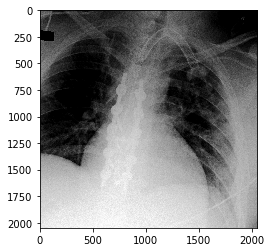

In [117]:
from matplotlib import pyplot as plt
i = 0
im = np.squeeze(imgs[i].numpy(),0)
print(im.shape)
plt.imshow(im, cmap='gray')
# masked_texts=txts
print(' '.join([idx2word[x] for x in txts.numpy()[i][:masks[i].numpy().sum()]]))
# print(masks[i].numpy())


In [122]:
np.random.choice([0,1,2,3,4])

1

In [123]:
im = Image.open('../data/ChestXRay/dataset/images/images_normalized/10_IM-0002-1001.dcm.png')

In [124]:
im.size

(2048, 2496)

In [156]:
mask.sum(-1)

tensor([45, 58, 35, 35, 39, 23, 67, 26])

In [333]:
%load_ext autoreload

In [614]:

import dataset
import importlib
importlib.reload(dataset)

<module 'dataset' from '/home/ipmi/code/dataset.py'>

In [530]:
from misc.config import Config
cfg = Config()

In [531]:
data_set = dataset.build_dataset('train',cfg=cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=8, drop_last=True,
                    shuffle=False, num_workers=0)
it = iter(train_loader)

In [532]:
imgs,caps,masks,uids,cap_lens=it.next()

-1.0 1.0


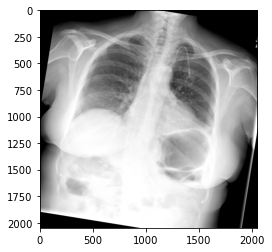

In [533]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
print(im.min(),im.max())
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

-0.12156862 0.45098042


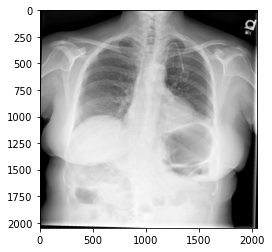

In [528]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
print(im.min(),im.max())
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

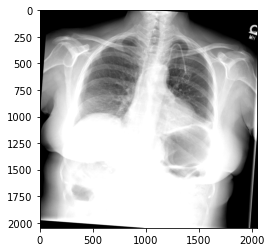

In [514]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
# print(im.shape)
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

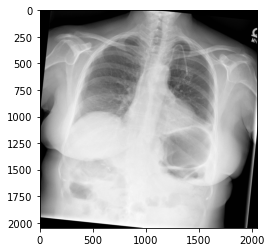

In [519]:
from matplotlib import pyplot as plt
i = 3
im = np.squeeze(imgs[i].numpy(),0)
# print(im.shape)
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

In [299]:
dataset['data_dict'][uids[i].tolist()]

{'filenames': ['19_IM-0583-1001.dcm.png'],
 'text': 'heart size is normal. there is tortuosity of the thoracic aorta, stable compared with prior. no focal airspace disease or effusion. no pleural effusions or pneumothoraces. degenerative changes in the thoracic spine.',
 'split': 0}

In [364]:
import torch.nn as nn
import math
# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        # self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.globalavg = nn.AdaptiveAvgPool1d(1)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, mask):

        src = self.encoder(src) * math.sqrt(self.ninp)
        print(src.shape)
        src = self.pos_encoder(src)
        word_feats = self.transformer_encoder(src, mask)  # max_len, batchsize, feats_size
        print('word_feats.shape:',word_feats.shape)
        word_feats = torch.transpose(word_feats, 1, 2)  # max_len, feats_size, batchsize
        print('word_feats.shape:',word_feats.shape)
        sent_feats = self.globalavg(word_feats[:, mask.sum(-1),:])
        print('sent_feats.shape:',sent_feats.shape)
        sent_feats = self.fc(sent_feats)
        return F.log_softmax(output, dim=-1)

In [368]:
imgs,caps,masks,uids=it.next()

In [369]:
# masks = mask
# masks.shape
caps.shape

torch.Size([8, 129])

In [382]:
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false
    In place operation
    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices[0], indices[1]] = maskval
################ Transformer: Text Encoder ############
class SelfAttention(nn.Module):
    def __init__(self, k, heads=8, mask=False):
        super().__init__()
        self.k, self.heads = k, heads
        # These compute the queries, keys and values for all 
        # heads (as a single concatenated vector)
        self.tokeys    = nn.Linear(k, k * heads, bias=False)
        self.toqueries = nn.Linear(k, k * heads, bias=False)
        self.tovalues  = nn.Linear(k, k * heads, bias=False)

        # This unifies the outputs of the different heads into 
        # a single k-vector
        self.unifyheads = nn.Linear(heads * k, k)
    def forward(self, x, mask):
        b, t, k = x.size()
        h = self.heads

        queries = self.toqueries(x).view(b, t, h, k)
        keys    = self.tokeys(x)   .view(b, t, h, k)
        values  = self.tovalues(x) .view(b, t, h, k)
        
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
        values = values.transpose(1, 2).contiguous().view(b * h, t, k)
        
        queries = queries / (k ** (1/4))
        keys    = keys / (k ** (1/4))

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        # - dot has size (b*h, t, t) containing raw weights

        
        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)
        
        dot = F.softmax(dot, dim=2) 
        # - dot now contains row-wise normalized weights
        
        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, k)
        
        out = out.transpose(1, 2).contiguous().view(b, t, h * k)
        return self.unifyheads(out)

class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, wide=True):
        super().__init__()
        self.attention = SelfAttention(k=emb, heads=heads)        
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )
        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x
    
    
class TEXT_TRANSFORMER_ENCODER(nn.Module):
    def __init__(self, emb, heads, depth, seq_length, num_tokens, dropout=0.2, wide=False):
        super().__init__()

        self.num_tokens = num_tokens
        self.wemb_linear  = nn.Linear(768, emb, bias=False)
        self.token_embedding = nn.Embedding(embedding_dim=768, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb
                                 , heads=heads
                                 , seq_length=seq_length
                                 , mask=True
                                 , dropout=dropout
                                 , wide=wide))

        self.tblocks = nn.Sequential(*tblocks)

        self.do = nn.Dropout(dropout)

    def init_embeddings(self, word_embedding, positional_embedding, IsTrainable):
        self.token_embedding.weight.data = word_embedding
        self.token_embedding.weight.requires_grad = IsTrainable
        
        self.pos_embedding.weight.data = positional_embedding
        self.pos_embedding.weight.requires_grad = False
        
        
    def forward(self, x,masks):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        tokens = self.wemb_linear(tokens)
        
        b, t, e = tokens.size()
#         print('b:{0}, t:{1}, e:{2}'.format(b, t, e))
        positions = torch.arange(t)        
        positions = self.pos_embedding(positions)[None, :, :].expand(b, t, e)
        
#         print('positions:',positions.size())
        x = tokens + positions
        x = self.do(x)

#         print('x:',x.size())
        words_emb = self.tblocks(x)
        sent_emb = words_emb.mean(dim=1) # pool over the time dimension
        words_emb = torch.transpose(words_emb,1,2)
        
#         print('words_emb:',words_emb.shape,'sent_emb:',sent_emb.shape)

        return words_emb,sent_emb

In [383]:
transformer_model = TEXT_TRANSFORMER_ENCODER(emb=512,heads=8,depth=4,seq_length=150,num_tokens=data_set.vocab_size)

In [384]:
transformer_model(caps,masks)

TypeError: forward() missing 1 required positional argument: 'mask'

In [386]:
from transformers import BertConfig, BertModel

In [388]:
config = BertConfig(vocab_size=1196, hidden_size=512, num_hidden_layers=3,
                    num_attention_heads=8, intermediate_size=2048, hidden_act='gelu',
                    hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1,
                    max_position_embeddings=512, layer_norm_eps=1e-12,
                    initializer_range=0.02, type_vocab_size=2, pad_token_id=0)

In [391]:
model = BertModel(config,add_pooling_layer=False )

In [392]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(1196, 512, padding_idx=0)
    (position_embeddings): Embedding(512, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

In [393]:
output = model(input_ids=caps, attention_mask=masks)

In [425]:
m = nn.AdaptiveAvgPool1d(1)
_input = torch.randn(1, 64, 8)
output = m(_input)
output.shape

torch.Size([1, 64, 1])

In [455]:
from transformers import BertPreTrainedModel

class TextEncoder(nn.Module):
    def __init__(self, config):
        super(TextEncoder, self).__init__()
        
        bert = BertModel(config, add_pooling_layer=False)

        self.bert = bert
        self.sent = nn.Linear(512, 512)
        
    def forward(self, x, mask):
        word_feat = self.bert(input_ids=x, attention_mask=mask)[0]
        print(word_feat.shape)
        sent_feat = word_feat[:,0,:]
        sent_feat = self.sent(sent_feat)       
        return sent_feat, word_feat

In [ ]:
word_feat = [129] ['CLS'] ['SEP'] ['PAD'] -> w_loss
word_feat[:,1:,:] -> [8,128,512] 

In [465]:
model = TextEncoder(config)

In [457]:
sent_feats, word_feats = model(caps,masks)

torch.Size([8, 129, 512])


In [466]:
std = model.state_dict()

In [467]:
std.keys()

odict_keys(['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weigh

In [469]:
std['bert.embeddings.word_embeddings.weight'][0,:] = 0.5
std['bert.embeddings.word_embeddings.weight']

tensor([[ 5.0000e-01,  5.0000e-01,  5.0000e-01,  ...,  5.0000e-01,
          5.0000e-01,  5.0000e-01],
        [-4.2670e-03, -2.2661e-02,  1.3596e-04,  ...,  5.9003e-03,
          4.3368e-02,  9.3442e-03],
        [ 2.3720e-02, -3.3314e-02, -5.4340e-03,  ...,  2.6354e-02,
          2.7614e-02, -7.6545e-03],
        ...,
        [-1.0447e-02, -4.0221e-02,  1.9034e-02,  ...,  5.2405e-03,
          1.2785e-02, -1.9273e-03],
        [ 4.7300e-02, -1.9325e-02, -1.7531e-02,  ...,  1.9294e-02,
         -1.9019e-03, -2.4678e-02],
        [-2.0812e-02, -2.3854e-02,  2.0967e-02,  ..., -5.1604e-03,
          3.7881e-02, -9.3478e-03]])

In [470]:
torch.save(std, 'save/temp.pth')

In [471]:
model2 = TextEncoder(config)

In [472]:
model2.state_dict()['bert.embeddings.word_embeddings.weight'][0]

tensor([ 7.8821e-03, -3.5045e-02,  1.4121e-02,  9.7070e-03, -3.3117e-03,
         9.6901e-03, -9.9555e-03, -1.8174e-02, -3.8385e-03, -1.5379e-02,
        -7.4687e-03,  1.5972e-03,  1.9328e-03,  1.9457e-02, -2.0138e-02,
         4.2976e-03, -9.5875e-03, -3.6648e-02, -1.6565e-02, -3.1241e-02,
        -5.4579e-03, -2.5698e-02,  6.6400e-03,  5.8831e-03,  1.5531e-02,
        -4.2414e-02,  1.3612e-02, -2.0310e-02, -8.0668e-03, -1.7462e-02,
         8.1628e-03, -1.9570e-02, -2.6664e-02,  6.3397e-03, -1.2849e-02,
        -3.0738e-02, -1.0288e-02,  1.9230e-02, -2.8008e-02,  2.0703e-02,
        -2.4501e-02,  3.3865e-02,  1.8946e-02, -2.1086e-03, -7.6355e-03,
        -1.2183e-02, -2.0348e-02, -2.1568e-02, -8.3113e-04,  2.7576e-02,
        -9.1024e-03, -7.6377e-03,  1.9110e-02,  4.4322e-03,  2.2333e-02,
        -3.4987e-02, -2.8900e-02,  1.5573e-02, -1.0295e-02, -8.2119e-03,
         2.0436e-02,  1.8305e-02,  1.1611e-02,  5.6134e-02,  8.8095e-03,
        -3.2502e-02,  6.2666e-03,  8.0496e-03, -1.4

In [473]:
tds = torch.load('save/temp.pth', map_location='cpu')
model2.load_state_dict(tds)

<All keys matched successfully>

In [474]:
model2.state_dict()['bert.embeddings.word_embeddings.weight'][0]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 

In [551]:
import model
importlib.reload(model)

<module 'model' from '/home/ipmi/code/model.py'>

In [552]:
md = model.ImageEncoder()

In [553]:
wf, sf = md(imgs)

torch.Size([8, 2048])


In [554]:
print(wf.shape, sf.shape)

torch.Size([8, 512, 16, 16]) torch.Size([8, 512])


In [626]:
im = Image.open('../data/ChestXRay/dataset/images/images_normalized/907_IM-2412-82526002.dcm.png')

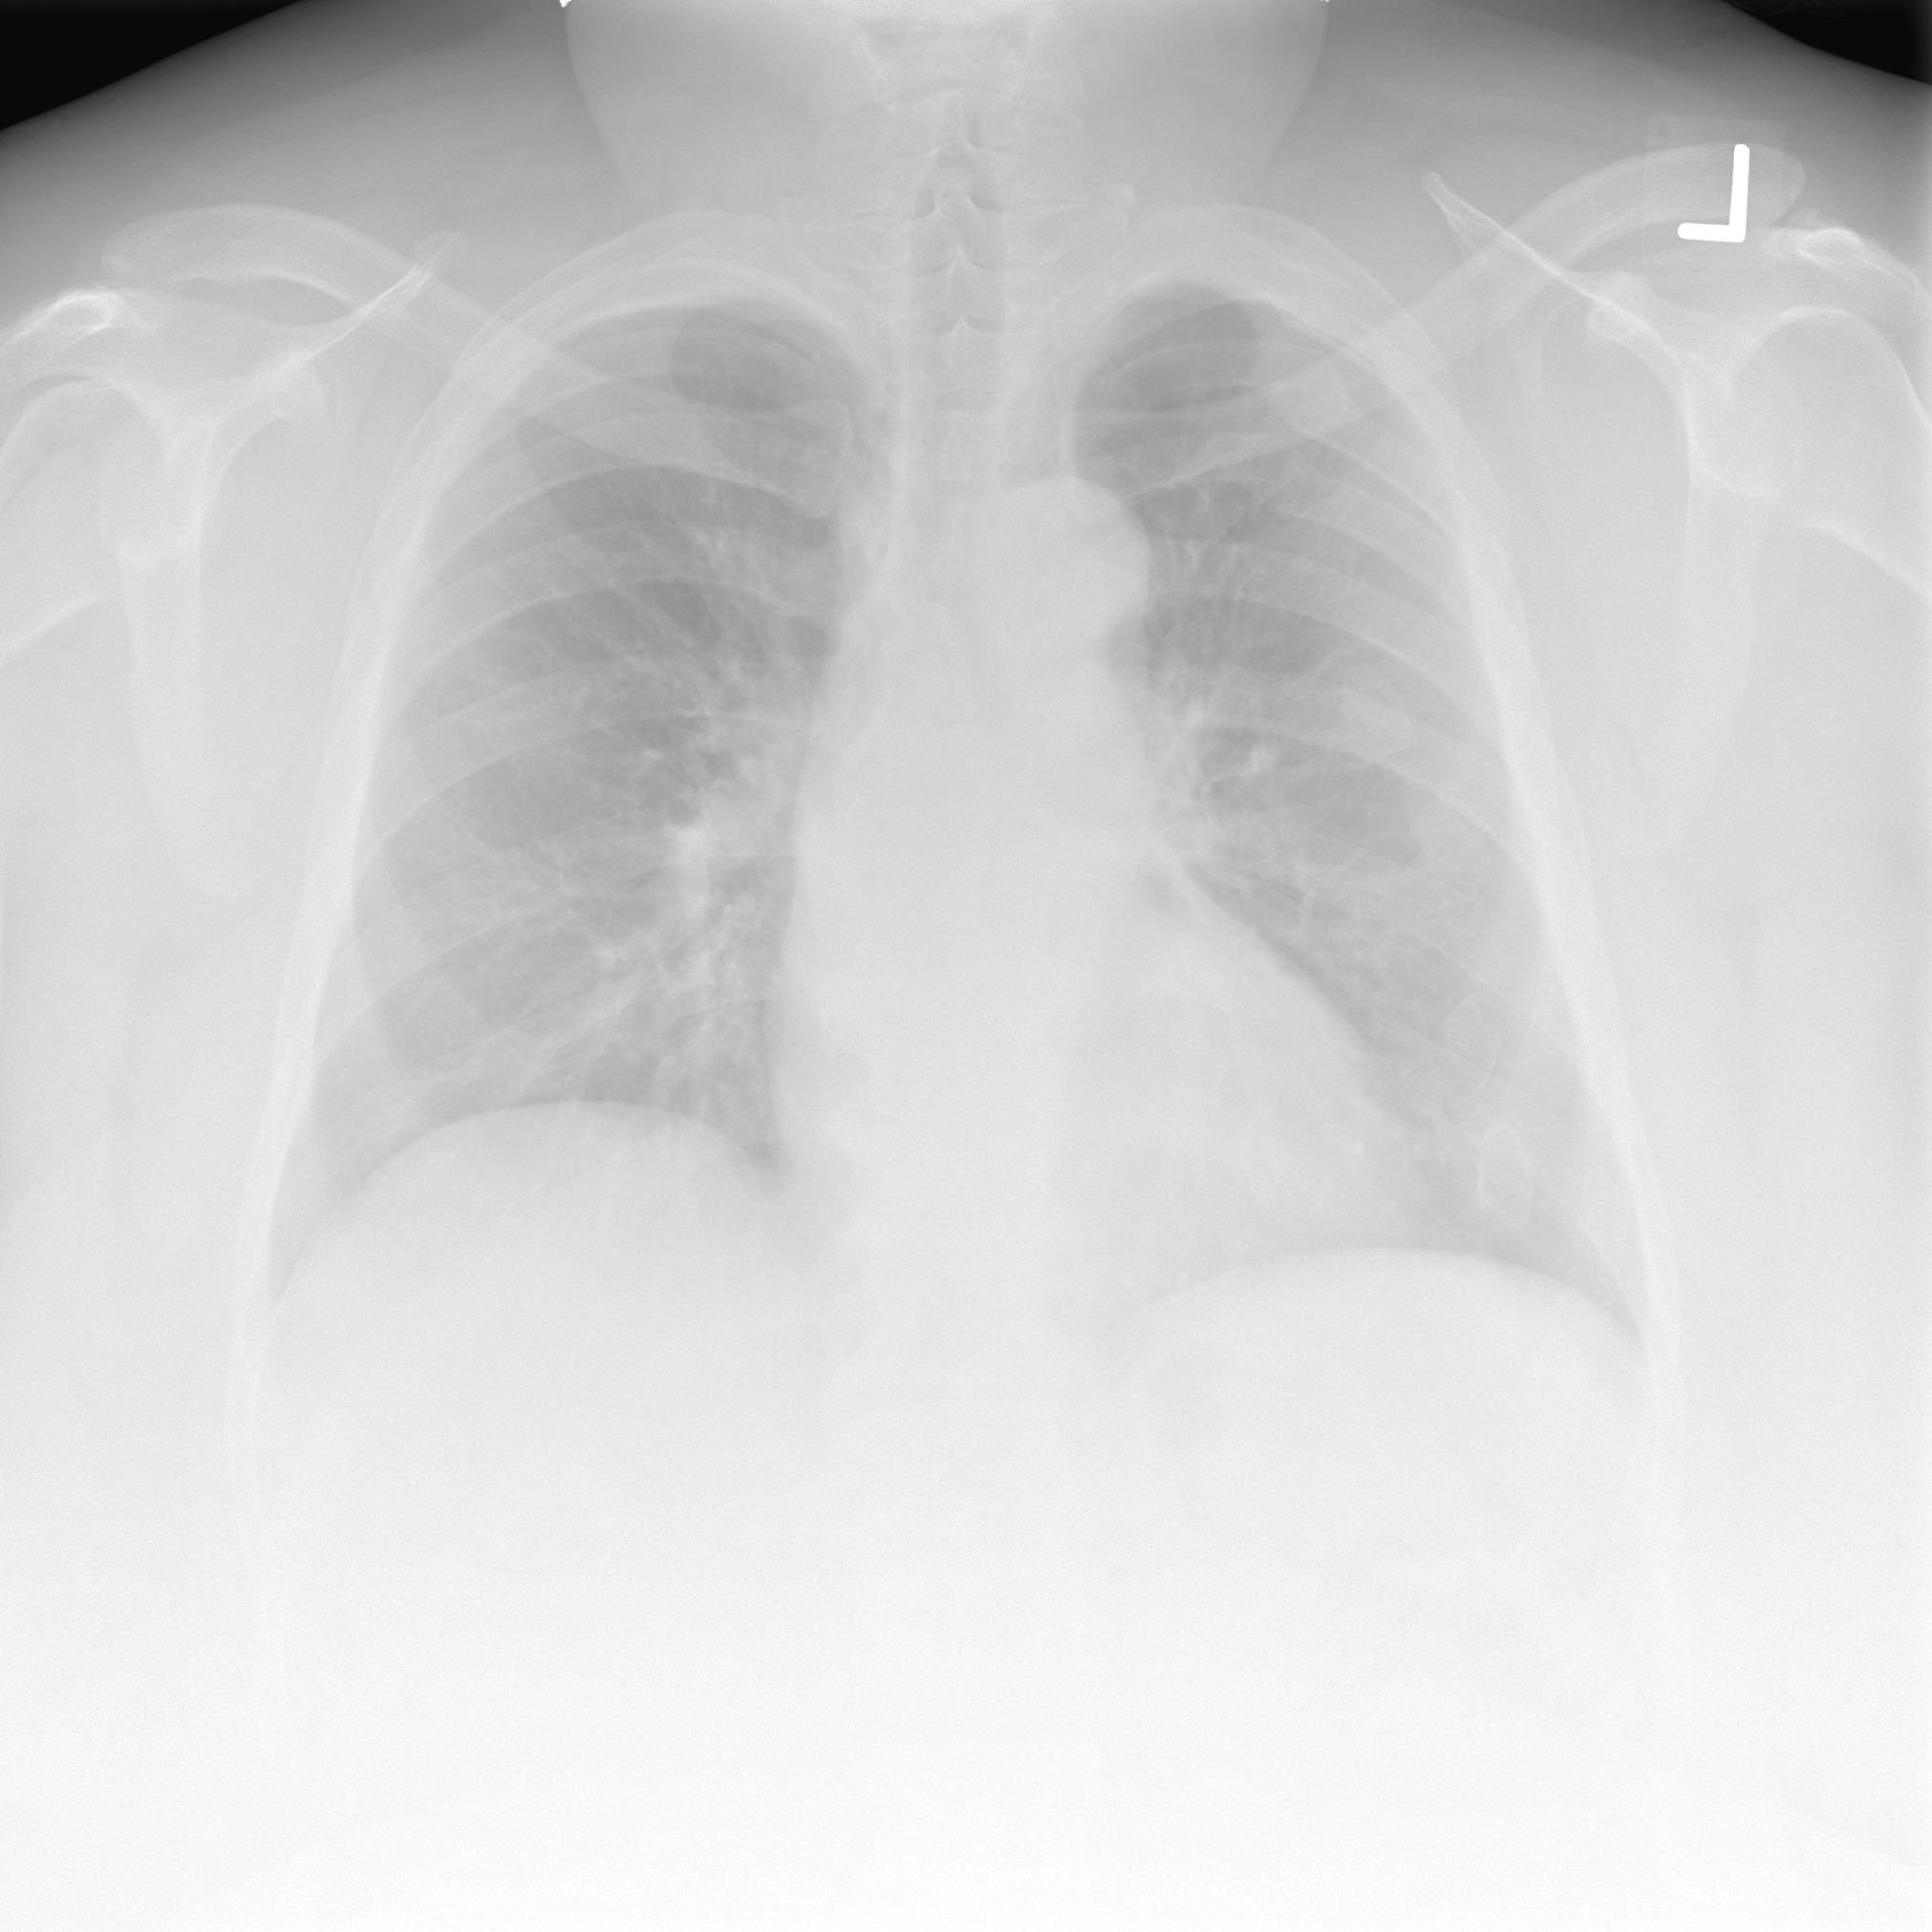

In [628]:
im

In [631]:
im.size

(2048, 2048)

In [630]:
im = im.resize((2048,2048))

In [632]:
im.save('../data/ChestXRay/dataset/images/images_normalized/907_IM-2412-82526002.dcm.png')

In [592]:
2048/im.size[0]

1.003921568627451

In [593]:
im.size[1]*1.003921568627451

2248.7843137254904

In [10]:
import dataset_mimic as dataset
import importlib
from misc.config import Config
cfg = Config()
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
importlib.reload(dataset)

<module 'dataset_mimic' from '/media/MyDataStor1/mmrl/IPMI2021/code/dataset_mimic.py'>

In [11]:

data_set = dataset.build_dataset('train',cfg=cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=32, drop_last=False,
                    shuffle=False, num_workers=0)
it = iter(train_loader)

In [12]:
image , caption, cap_mask, uid, cap_lens = it.next()

[Errno 2] No such file or directory: '/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15398519/s52897917/6f9899f3-652a0fe6-cb32f8b1-3afb0c85-5a3929f0.jg'
/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15398519/s52897917/6f9899f3-652a0fe6-cb32f8b1-3afb0c85-5a3929f0.jg


UnboundLocalError: local variable 'image' referenced before assignment

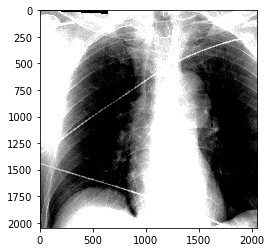

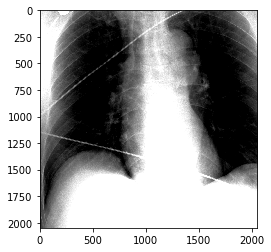

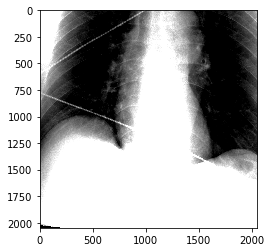

In [23]:
plt.imshow((image[0].numpy()[0]+1)/2,cmap='gray')
plt.show()
plt.imshow((image[1].numpy()[0]+1)/2,cmap='gray')
plt.show()
plt.imshow((image[2].numpy()[0]+1)/2,cmap='gray')
plt.show()

In [14]:
from PIL import Image
import os, pickle

In [9]:
try:
#     Image.open('/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p11/p11378535/s50374044/db9511e3-ee0359ab-489c3556-4a9b2277-c0bf0369.jpg')
#     # Image.open('/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p18/p18441078/s58044074/15e60dc7-6493889f-d2cb9dba-2c860709-f171bc98.jpg')
#     # Image.open('/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p19/p19017919/s50797181/8e5f8df3-4248d575-fd16f8c1-1c69065a-1ac199e9.jpg')
#     # Image.open('/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14887088/s54257662/1bc85033-355accce-e8d0ed50-78188cd3-dac92e86.jpg')
#     # Image.open('/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p11/p11285576/s54979966/03b2e67c-70631ff8-685825fb-6c989456-621ca64d.jpg')
#     # Image.open('/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p11/p11673861/s53517205/0491306a-d44bb1cd-36678cdf-ef64aa11-ee9897a2.jpg')
    Image.open('/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15398519/s52897917/6f9899f3-652a0fe6-cb32f8b1-3afb0c85-5a3929f0.jpg').convert('L').size
except Exception as ex:
    print(ex)

In [146]:
frontal_ds[frontal_ds.subject_id==19017919][frontal_ds.img=='files/p19/p19017919/s50797181/8e5f8df3-4248d575-fd16f8c1-1c69065a-1ac199e9.dcm']


/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split
219459,340171,19017919,50797181,8e5f8df3-4248d575-fd16f8c1-1c69065a-1ac199e9,files/p19/p19017919/s50797181/8e5f8df3-4248d57...,files/p19/p19017919/s50797181.txt,AP,2544,3056,train


In [147]:
frontal_ds[frontal_ds.subject_id==19017919].sort_values(by='study_id')

,uid,subject_id,study_id,dicom_id,img,txt,ViewPosition,Rows,Columns,split
219454,340166,19017919,50336583,1af74338-17ac5383-c2614376-b98fd4af-00869b31,files/p19/p19017919/s50336583/1af74338-17ac538...,files/p19/p19017919/s50336583.txt,AP,2544,3056,train
219455,340167,19017919,50336583,68702b51-e74cbf50-69888438-b6c06a18-f6157e86,files/p19/p19017919/s50336583/68702b51-e74cbf5...,files/p19/p19017919/s50336583.txt,AP,2544,3056,train
219456,340168,19017919,50358951,ad5fe998-98f35740-b82aa962-002ad770-195c7ad8,files/p19/p19017919/s50358951/ad5fe998-98f3574...,files/p19/p19017919/s50358951.txt,AP,2489,3050,train
219457,340169,19017919,50415109,2a584501-e364b327-5354faa8-ce837ef9-a85e022f,files/p19/p19017919/s50415109/2a584501-e364b32...,files/p19/p19017919/s50415109.txt,AP,2539,3050,train
219458,340170,19017919,50566971,613f114d-c05de583-fb5e30f4-d89c8f30-5d483b3a,files/p19/p19017919/s50566971/613f114d-c05de58...,files/p19/p19017919/s50566971.txt,AP,2539,3050,train
219459,340171,19017919,50797181,8e5f8df3-4248d575-fd16f8c1-1c69065a-1ac199e9,files/p19/p19017919/s50797181/8e5f8df3-4248d57...,files/p19/p19017919/s50797181.txt,AP,2544,3056,train
219460,340172,19017919,51025673,38d5eacf-bc522360-4e24539a-79a3ef78-f3cbd034,files/p19/p19017919/s51025673/38d5eacf-bc52236...,files/p19/p19017919/s51025673.txt,AP,2539,3050,train
219461,340173,19017919,51093577,0200000d-d6f6590a-d0ef4db6-09cdb611-792c4844,files/p19/p19017919/s51093577/0200000d-d6f6590...,files/p19/p19017919/s51093577.txt,AP,2539,3050,train
219462,340174,19017919,51093577,6eb248f1-613a1c66-ab3c6029-8fc9a645-49644dff,files/p19/p19017919/s51093577/6eb248f1-613a1c6...,files/p19/p19017919/s51093577.txt,AP,2539,3050,train
219463,340175,19017919,51206820,37331e64-fb756a05-f774a0ce-c3d41295-f712a8a6,files/p19/p19017919/s51206820/37331e64-fb756a0...,files/p19/p19017919/s51206820.txt,AP,2525,3050,train


In [15]:
data_dir = '/media/MyDataStor2/MIMIC-CXR'
root_img_path = '/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/'
with open(os.path.join(data_dir,'lm_reports/mimic_dataset_mit_normalized.pkl'),'rb') as f:
    dataset_pkl = pickle.load(f)
for uid in tqdm(dataset_pkl['data_dict'].keys()):
    fns = dataset_pkl['data_dict'][uid]['filenames']
    for img in fns:
        p = os.path.join(root_img_path,img.replace('dcm','jpg'))
        try:
            im = Image.open(p).convert('L')
            if (im.size[0]<1024) or (im.size[1]<1024):
    #             print(im.shape)
                raise Exception
        except Exception as ex:
            print(p)
            print(ex)

 31%|███       | 69235/225293 [1:09:51<2:00:36, 21.57it/s]

/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13118941/s54144739/67b68818-61703959-6321083a-ecf0ff32-addd5bc8.jpg
broken data stream when reading image file


 36%|███▌      | 81298/225293 [1:22:09<2:07:40, 18.80it/s]

/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13660399/s52532898/2f2d7a89-161059ab-bf24aaa4-c15f7abb-ea408fee.jpg
broken data stream when reading image file


 48%|████▊     | 108088/225293 [1:49:38<1:52:39, 17.34it/s]

/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p14/p14882082/s59150331/5009240f-7dc4006c-4a69d332-00051c01-9179f001.jpg
broken data stream when reading image file


 71%|███████   | 160003/225293 [2:43:19<55:57, 19.45it/s]  

/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p17/p17198774/s54162995/2d7e35ed-6f80d557-740804a5-c1cdc6f0-5729e6a6.jpg
broken data stream when reading image file


 71%|███████   | 160012/225293 [2:43:20<58:41, 18.54it/s]  

/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p17/p17199342/s59731194/b3e8c46c-99efe614-59b11837-a870ab41-8e30ceea.jpg
broken data stream when reading image file


 83%|████████▎ | 187765/225293 [3:12:08<1:04:05,  9.76it/s]

/media/MyDataStor2/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p18/p18446282/s54914372/32b63c6b-837955f2-62cd29e6-834d5132-6f9c67d8.jpg
broken data stream when reading image file


100%|██████████| 225293/225293 [3:51:18<00:00, 16.23it/s]  


In [43]:
dataset_pkl['data_dict'][uid]

{'filenames': ['files/p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm'],
 'text': 'There is no focal consolidation , pleural effusion or pneumothorax . Bilateral nodular opacities that most likely represent nipple shadows . The cardiomediastinal silhouette is normal . Clips project over the left lung , potentially within the breast . The imaged upper abdomen is unremarkable . Chronic deformity of the posterior left NUMBER and NUMBER ribs are noted . No acute cardiopulmonary process .',
 'split': 0,
 'official_split': 0,
 'token_ids': [1,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  5,
  25,
  26,
  27,
  28,
  22,
  29,
  30,
  31,
  32,
  22,
  33,
  22,
  34,
  35,
  36,
  5,
  37,
  38,
  39,
  40,
  22,
  41,
  29,
  42,
  43,
  42,
  44,
  45,
  46,
  6,
  47,
  48,
  49,
  2]}

In [31]:
# cfg.

SyntaxError: invalid syntax (<ipython-input-31-c2ff6a2e9c94>, line 1)

In [ ]:
'/media/MyDataStor2/MIMIC-CXR/lm_reports/'